In [ ]:
import pandas as pd


ia_rep = pd.read_csv(
    "../../ln_shared_data/onestop/processed/readability/OneStop_v1_20250101_ia_P_aligned.csv",
    engine="pyarrow",
)
ia_not_aligned = pd.read_csv(  # needed to add columns that are not in `ia_rep`
    "../../ln_shared_data/onestop/OneStop_v1_20250113/lacclab_processed/ia_Paragraph.csv",
    engine="pyarrow",
)

fix_rep = pd.read_csv(
    "../../ln_shared_data/onestop/OneStop_v1_20250113/lacclab_processed/fixations_Paragraph.csv",
    engine="pyarrow",
)

In [ ]:
ia_rep.rename(
    columns={
        "subject_id": "participant_id",
        "reread": "repeated_reading_trial",
        "article_ind": "article_index",
    },
    inplace=True,
)

In [ ]:
columns_to_add = ia_not_aligned.columns.difference(ia_rep.columns)
columns_to_add

Index(['EleutherAI/pythia-70m_surprisal', 'IA_DWELL_TIME',
       'IA_FIRST_FIXATION_DURATION', 'IA_FIRST_FIX_PROGRESSIVE',
       'IA_FIRST_RUN_DWELL_TIME', 'IA_FIXATION_COUNT',
       'IA_REGRESSION_PATH_DURATION', 'article_batch', 'article_index',
       'difficulty_level', 'list_number', 'practice_trial',
       'prev_EleutherAI/pythia-70m_surprisal', 'question_preview',
       'text_onscreen_version', 'text_spacing_version'],
      dtype='object')

In [ ]:
trial_key_cols = ["participant_id", "unique_paragraph_id", "repeated_reading_trial"]
ia_aligned = ia_rep.merge(
    ia_not_aligned[trial_key_cols + list(columns_to_add) + ["IA_ID"]],
    on=trial_key_cols + ["IA_ID"],
    how="left",
)


In [ ]:
ia_rep[
    ["participant_id", "unique_paragraph_id", "repeated_reading_trial"]
].drop_duplicates().tail(80)

,participant_id,unique_paragraph_id,repeated_reading_trial
2523798,l1_322,3_8_Ele_3,0
2523895,l1_322,3_8_Ele_4,0
2523993,l1_322,3_8_Adv_5,0
2524081,l1_322,3_8_Adv_6,0
2524204,l1_322,3_8_Adv_1,1
...,...,...,...
2532288,l2_324,3_6_Ele_3,1
2532356,l2_324,3_6_Adv_4,1
2532461,l2_324,3_6_Ele_5,1
2532571,l2_324,3_6_Adv_6,1


In [ ]:
ia_rep[(ia_rep["participant_id"] == "l23_234")][
    ["unique_paragraph_id", "participant_id"]
].drop_duplicates().tail(10)

,unique_paragraph_id,participant_id
2231052,2_9_Ele_1,l23_234
2231156,2_9_Ele_2,l23_234
2231231,2_9_Ele_3,l23_234
2231335,2_9_Adv_4,l23_234
2231487,2_9_Ele_5,l23_234
2231605,2_9_Adv_6,l23_234
2231730,2_3_Adv_1,l23_234
2231865,2_3_Adv_2,l23_234
2232012,2_3_Ele_3,l23_234
2232106,2_3_Adv_4,l23_234


In [ ]:
def get_trial(
    ia_rep,
    fix_rep,
    subj_id,
    p_id,
    repeated_reading_trial,
    ignore_refixations: bool = True,
):
    sub_ia = ia_rep[
        (ia_rep["participant_id"] == subj_id)
        & (ia_rep["unique_paragraph_id"] == p_id)
        & (ia_rep["repeated_reading_trial"] == repeated_reading_trial)
    ]

    sub_fix = fix_rep[
        (fix_rep["participant_id"] == subj_id)
        & (fix_rep["unique_paragraph_id"] == p_id)
        & (fix_rep["repeated_reading_trial"] == repeated_reading_trial)
    ]

    if ignore_refixations:
        sub_fix = sub_fix.query(
            "CURRENT_FIX_INTEREST_AREA_INDEX != NEXT_FIX_INTEREST_AREA_INDEX"
        )

    return sub_ia, sub_fix

In [ ]:
import matplotlib

fontsize = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from operator import itemgetter


class ArcDiagram:
    def __init__(self, *args):
        if len(args) != 2:
            self.help()
            raise ValueError("ArcDiagram(node_list, title_string) takes 2 arguments.")

        self.__nodes = args[0]
        self.__title = args[1]
        self.__arc_coordinates = []
        self.__colors = plt.cm.viridis(np.linspace(0, 1, len(self.__nodes)))
        self.__background_color = "white"
        self.__label_rotation_degree = 0
        self.__legend_labels = []

    def connect(self, start_node, end_node, linewidth=0.1, arc_position="above"):
        start = self.__nodes.index(start_node)
        end = self.__nodes.index(end_node)

        if start != end:
            arc_center = (start + end) / 2
            radius = abs(end - start) / 2

            if arc_position == "below":
                theta = np.linspace(180, 360, 100)
            else:
                theta = np.linspace(0, 180, 100)

            x = arc_center + radius * np.cos(np.radians(theta))
            y = radius * np.sin(np.radians(theta))
            self.__arc_coordinates.append((x, y, start, linewidth))
        else:
            raise ValueError(
                "Self loops are currently not supported. Please use different nodes."
            )

    def help(self):
        function_list = """
        ArcDiagram(node_list, title_string)
        .set_background_color(string)
        .set_color_map(string)
        .set_custom_colors(color_list)
        .set_label_rotation_degree(arc_degree)
        .set_legend_labels(list_of_labels)
        .connect(start, end, linewidth=100, arc_position="below")
        .show_plot()
        .save_plot_as(file_name, resolution="100")
        """
        print(function_list)

    def set_background_color(self, color):
        self.__background_color = color

    def set_color_map(self, color_map_name):
        color_map = colormaps[color_map_name]
        self.__colors = color_map(np.linspace(0, 1, len(self.__nodes)))

    def set_custom_colors(self, color_list):
        self.__colors = ListedColormap(color_list).colors

    def set_label_rotation_degree(self, degree):
        self.__label_rotation_degree = degree

    def set_legend_labels(self, legend_labels):
        self.__legend_labels = legend_labels

    def save_plot_as(self, file_name, resolution="figure"):
        # Overhauled so we can reuse __plot() logic
        fig, ax = self.__plot()  # This creates a new figure
        plt.savefig(file_name, dpi=resolution, bbox_inches="tight")

    def show_plot(self):
        # Overhauled so we can reuse __plot() logic
        fig, ax = self.__plot()  # This creates a new figure
        plt.show()

    def plot_on_axis(self, ax):
        """
        Public method to plot on an *existing* Axes object.
        It re-uses __plot logic but avoids creating new figure or calling plt.show().
        """
        self.__plot(ax=ax)

    def __label_color_distribution(self, colors, n):
        if n <= 0:
            return []

        step = (len(colors) - 1) / (n - 1)
        indices = [round(i * step) for i in range(n)]
        return [colors[i] for i in indices]

    def __plot(self, ax=None):
        """
        Core plot method. If ax is None, create a new figure + axes. Otherwise, plot on the passed ax.
        Returns (fig, ax) for consistency.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(30, 6))
        else:
            # If ax was passed in, get the figure from it
            fig = ax.figure

        ax.set_facecolor(self.__background_color)

        # plot nodes as points
        node_positions = np.arange(len(self.__nodes))
        ax.scatter(
            node_positions, np.zeros_like(node_positions), color=self.__colors, s=100
        )

        # Find max "linewidth" to scale arcs properly
        if len(self.__arc_coordinates) > 0:
            max_value = max(self.__arc_coordinates, key=itemgetter(3))[3]
        else:
            max_value = 1

        # We'll just pick some "reasonable" y-limits. Adjust as you like.
        ylim_top = 10
        ylim_bottom = -10

        # Plot connections as arcs
        for x, y, index, raw_linewidth in self.__arc_coordinates:
            # bound y values
            y = [min(ylim_top, max(ylim_bottom, val)) for val in y]

            ax.plot(
                x,
                y,
                color=self.__colors[index],
                zorder=1,
                linewidth=self._map_to_linewidth(raw_linewidth, max_value),
            )

        # cosmetic stuff
        ax.set_xticks(node_positions)
        ax.set_xticklabels(
            map(lambda x: " ".join(x.split(" ")[1:]), self.__nodes),
            rotation=self.__label_rotation_degree,
            fontsize=fontsize / 1.5,
        )
        # rotate xtick labels by 45 degrees
        # plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_yticks([])
        ax.set_title(self.__title, fontsize=fontsize)

        # Add a legend if user provided labels
        if self.__legend_labels != []:
            legend_labels = self.__legend_labels
            label_colors = self.__label_color_distribution(
                self.__colors, len(legend_labels)
            )
            ax.legend(
                handles=[
                    plt.Line2D(
                        [0],
                        [0],
                        marker="o",
                        color="w",
                        label=label,
                        markerfacecolor=label_colors[i],
                        markersize=10,
                    )
                    for i, label in enumerate(legend_labels)
                ],
                loc="upper right",
            )

        return fig, ax

    def _map_to_linewidth(self, value, max_value):
        if value < 1:
            return 1
        else:
            return (10 * value) / max_value


In [ ]:
def create_arc_diagram(nodes, node_colors, connections, title):
    arc_diagram = ArcDiagram(nodes, title)
    arc_diagram.set_label_rotation_degree(90)
    arc_diagram.set_custom_colors(node_colors)

    for u, v, above in connections:
        if u == v:
            raise ValueError("Self loops are currently not supported.")
        arc_diagram.connect(u, v, arc_position="below" if not above else "above")

    return arc_diagram  # <--- return the ArcDiagram object without showing


First Reading Saccades
Repeated Reading Saccades


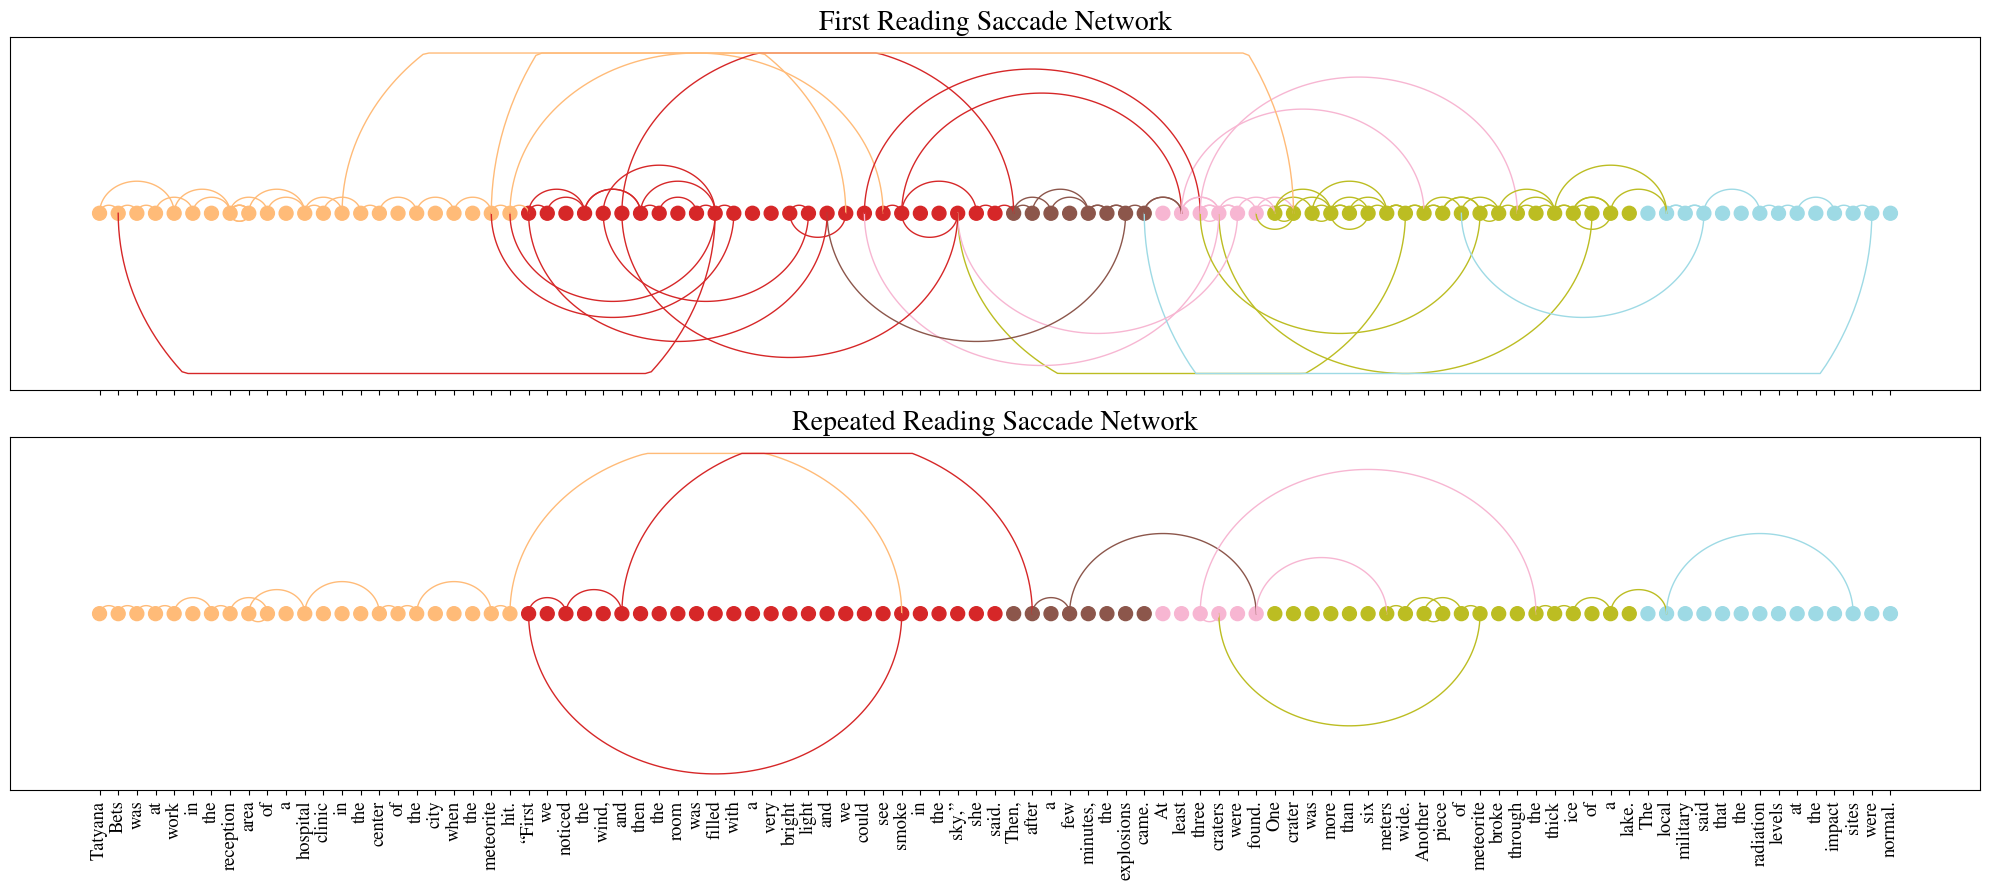

In [ ]:
import pandas as pd
from typing import Literal

pd.options.mode.chained_assignment = None


def extract_arcplot_components(
    sub_ia, sub_fix, arc_mode: Literal["Saccades", "Dependency"]
):
    # Make a list that is "<IA_ID>: <IA_LABEL>" for the paragraph
    sub_ia["node_names"] = (
        sub_ia[["IA_ID", "IA_LABEL"]]
        .apply(lambda x: f"({x['IA_ID']}) {x['IA_LABEL']}", axis=1)
        .tolist()
    )
    sub_ia["node_colors"] = sub_ia["sentence_idx"].astype(int).tolist()
    # Make the node_colors actual colors according to the sentence_idx using categorical colormap
    colormap = ListedColormap(
        colormaps["tab20"](np.linspace(0, 1, sub_ia["sentence_idx"].nunique() + 1))
    )
    sub_ia["node_colors"] = sub_ia["node_colors"].apply(lambda x: colormap(x))

    nodes = sub_ia["node_names"].tolist()

    # Add the arcs
    arc_ids_lst = sub_fix.query("NEXT_FIX_INTEREST_AREA_INDEX > 0")[
        ["CURRENT_FIX_INTEREST_AREA_INDEX", "NEXT_FIX_INTEREST_AREA_INDEX"]
    ]

    if arc_mode == "Saccades":
        # Replace the indices with the node names in the arc_ids_lst
        connections = arc_ids_lst.apply(
            lambda x: (
                nodes[int(x["CURRENT_FIX_INTEREST_AREA_INDEX"])],  # src
                nodes[int(x["NEXT_FIX_INTEREST_AREA_INDEX"])],  # dst
                int(x["CURRENT_FIX_INTEREST_AREA_INDEX"])
                < int(x["NEXT_FIX_INTEREST_AREA_INDEX"]),  # is progression?
            ),
            axis=1,
        ).tolist()
    elif arc_mode == "Dependency":
        # sub_ia["head_word_index"] contains the index of the head word of each word
        sub_ia["head_word_index"] = sub_ia["head_word_index"] - 1
        connections = sub_ia.apply(
            lambda x: (
                nodes[x["IA_ID"]],
                nodes[x["head_word_index"]],
                x["head_word_index"] > x["IA_ID"],
            ),
            axis=1,
        ).tolist()
    else:
        raise ValueError("arc_mode must be either 'Saccades' or 'Dependency'")

    return nodes, sub_ia["node_colors"].tolist(), connections


def plot_arc_diagram(arc_diagram):
    arc_diagram.show_plot()


def create_trial_arc_plot(sub_ia, sub_fix, subj_id, p_id, arc_mode="Dependency"):
    nodes, node_colors, connections = extract_arcplot_components(
        sub_ia, sub_fix, arc_mode
    )
    title = f"Subject: {subj_id}, Paragraph: {p_id}"
    arc_diagram = create_arc_diagram(nodes, node_colors, connections, title)
    plot_arc_diagram(arc_diagram)


p_id = "3_8_Ele_3"
subj_id = "l1_322"


def plot_three_arcplots(ia_rep, fix_rep, subj_id, p_id):
    """
    Example function that creates and stacks three arcplots (Saccades 1,
    Saccades 2, Dependency) in a single figure with shared x-axis.
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 9))

    # First reading saccades
    print("First Reading Saccades")
    sub_ia, sub_fix = get_trial(
        ia_rep,
        fix_rep,
        subj_id,
        p_id,
        repeated_reading_trial=0,
        ignore_refixations=True,
    )
    nodes, node_colors, connections = extract_arcplot_components(
        sub_ia, sub_fix, "Saccades"
    )
    arc_diagram_s1 = create_arc_diagram(
        nodes,
        node_colors,
        connections,
        title="First Reading Saccade Network",
    )
    arc_diagram_s1.plot_on_axis(axes[0])

    # Repeated reading saccades
    print("Repeated Reading Saccades")
    sub_ia, sub_fix = get_trial(
        ia_rep,
        fix_rep,
        subj_id,
        p_id,
        repeated_reading_trial=1,
        ignore_refixations=True,
    )
    nodes, node_colors, connections = extract_arcplot_components(
        sub_ia, sub_fix, "Saccades"
    )
    arc_diagram_s2 = create_arc_diagram(
        nodes,
        node_colors,
        connections,
        title="Repeated Reading Saccade Network",
    )
    arc_diagram_s2.plot_on_axis(axes[1])

    # edit the x labels to lambda x: x.split(" ")[1:].join(" ") Notice that get_xticklabels gets you Text objects

    # # Dependency arcs
    # print("Dependency Arcs")
    # sub_ia, sub_fix = get_trial(
    #     ia_rep, fix_rep, subj_id, p_id, repeated_reading_trial=0
    # )
    # nodes, node_colors, connections = extract_arcplot_components(
    #     sub_ia, sub_fix, "Dependency"
    # )
    # arc_diagram_dep = create_arc_diagram(
    #     nodes, node_colors, connections, title=f"{subj_id}, {p_id} (Dependency Arcs)"
    # )
    # arc_diagram_dep.plot_on_axis(axes[2])

    # Adjust subplot layout
    plt.tight_layout()
    plt.show()

    return fig


arcfig = plot_three_arcplots(ia_rep, fix_rep, subj_id, p_id)

In [ ]:
# export arcfig to pdf

arcfig.savefig("../figures/arcfig.pdf", bbox_inches="tight")
